In [1]:
import torchvision.transforms as transforms                 # Import transformations we will apply to data when loading dataset
import torchvision                                          # For downloading dataset
import torch                                                # For getting an iterable over dataset
import torch.nn as nn                                       # For architecture and loss function
import torch.nn.functional as F                             # For activation function

import matplotlib.pyplot as plt                             # For visualizing a sample of the dataset
import numpy as np                                          # For visualizing a sample of the dataset



In [2]:
####################################################################################
# Setup device configuration (so we can use cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#################################################################################################################
###################################### DECLARE HYPER-PARAMETERS/GLOBAL VARIABLES ################################
# Declare global variables we will be using later
data_directory = './image_data'
batch_size = 4
learning_rate = 0.001
num_epochs = 15



In [3]:
##################################################################################################################
#################################### IMPORT DATA AND APPLY TRANSFORMATIONS #######################################
##################################################################################################################

# Use transforms.Compose to apply the following transforms one after another
#       1. Transform dataset to being in a pytorch tensor with use of .ToTensor()
#       2. Make dataset have mean of 0.5 and standard deviation of 0.5 in all 3 channels with use of .Normalize
#               .Normalize((channel_1_mean, channel_2_mean, channel_3_mean), (channel_1_std_dev, channel_2_std_dev, channel_3_std_dev))
#               Input data has 3 channels because image data is in color and colors are made from 3 colors (red, green, blue AKA rgb)
#               which stand for the 3 color channels/input channels
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Import the actual data AND apply transforms when importing
#       Data is 60,000 32x32 color images
#       Data has 10 different classes and 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root=data_directory, train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root=data_directory, train=False,
                                       download=True, transform=transform)

# Get an iterable we can use to iterate over training and testing data
#       shuffle=True means reshuffle data every epoch
#       shuffle=False means do not reshuffle data every epoch
#       Since we will iterate over training dataset multiple times (we will have multiple epochs), shuffle should
#           be true for train_loader
#       But since we will only iterate over testing dataset once (we will not have multiple epochs), shuffle should
#           be false for test_loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                         shuffle=False)

# Declare classes that correspond to each index of "labels" (later declared)
#       so we can print out the accuracy of each class in the end when evaluating our model
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Extracting ./image_data/cifar-10-python.tar.gz to ./image_data
Files already downloaded and verified


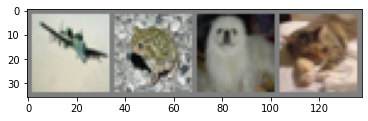

In [4]:
# Define helper function to help us visualize some sample images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Show some sample images
imshow(torchvision.utils.make_grid(images))




In [5]:
# Declare architecture of neural network
class ConvNet(nn.Module):
    # Declare __init__ function for initialization
    def __init__(self):
        # Inheritance
        super(ConvNet, self).__init__()
        
        # Declare multiple convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1)

        # Declare pooling function
        self.pool = nn.MaxPool2d(kernel_size = 3, stride=1, padding=1, dilation=1)
        
        # Declare fully connected "fc" layers
        self.fc1 = nn.Linear(128*32*32, 3*8*8)
        self.fc2 = nn.Linear(3*8*8, 10)

    # Declare forward pass function so we can override the default forward behavior
    def forward(self, x):
        # Input is of shape -> n, 3, 32, 32 where n is batch_size
        
        # Apply convolution -> activation function -> pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten data before fully connected layers
        x = x.view(-1, 128*32*32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Create an instance of neural network so we can use it to train
model = ConvNet().to(device)

print(model)


ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=10, bias=True)
)


In [6]:
#########################################################################################################
#########################################################################################################
###################################### DEFINE LOSS AND OPTIMIZER ########################################
# Declare loss function
criterion = nn.CrossEntropyLoss()

# Declare optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)




In [7]:
##########################################################################################################
########################################### TRAINING #####################################################
# Training loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        # Always zero out the gradient to make sure that we don't have stuff in gradient from previous iterations
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Print that we have finished training and save the model to the path specified
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

# Evaluate our model here
# Also use torch.no_grad() to ensure we are not automatically calculating gradients for evaluation of model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    # Print accuracy for all 10 classes together
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    # Print accuracy for each class
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Epoch [1/15], Step [1000/12500], Loss: 2.1882
Epoch [1/15], Step [2000/12500], Loss: 2.1552
Epoch [1/15], Step [3000/12500], Loss: 1.9062
Epoch [1/15], Step [4000/12500], Loss: 1.6666
Epoch [1/15], Step [5000/12500], Loss: 1.5773
Epoch [1/15], Step [6000/12500], Loss: 2.5428
Epoch [1/15], Step [7000/12500], Loss: 0.6808
Epoch [1/15], Step [8000/12500], Loss: 2.1945
Epoch [1/15], Step [9000/12500], Loss: 1.1998
Epoch [1/15], Step [10000/12500], Loss: 0.5844
Epoch [1/15], Step [11000/12500], Loss: 1.3047
Epoch [1/15], Step [12000/12500], Loss: 1.4733
Epoch [2/15], Step [1000/12500], Loss: 1.2725
Epoch [2/15], Step [2000/12500], Loss: 1.0269
Epoch [2/15], Step [3000/12500], Loss: 0.4414
Epoch [2/15], Step [4000/12500], Loss: 1.9899
Epoch [2/15], Step [5000/12500], Loss: 0.9868
Epoch [2/15], Step [6000/12500], Loss: 1.6356
Epoch [2/15], Step [7000/12500], Loss: 0.9005
Epoch [2/15], Step [8000/12500], Loss: 1.5832
Epoch [2/15], Step [9000/12500], Loss: 0.7232
Epoch [2/15], Step [10000/12500

In [13]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())
# https://colab.research.google.com/github/agungsantoso/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%206%20-%20Saving%20and%20Loading%20Models.ipynb

Our model: 

 ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=10, bias=True)
) 

The state dict keys: 

 odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [11]:
torch.save(model.state_dict(), 'CIFAR10-1.19.21-Accuracy76.pth')
from google.colab import files
files.download('CIFAR10-1.19.21-Accuracy76.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>